In [2]:
using LinearAlgebra
using Plots
using SparseArrays
using Arpack #Eigenvalues of sparse arrays with eigs()
using DifferentialEquations
# using DiffEqFlux
# using Optim
# using ForwardDiff
using DelimitedFiles
# using LineSearches
using LaTeXStrings


In [3]:
#Def parameters
n_cutoff = 8
N = 2 * n_cutoff + 1
NHilbert = N^2
n = sparse(Diagonal(LinRange(-n_cutoff, n_cutoff, N))) #Perhaps implement using StaticArrays
Id = sparse(I, N, N)
exp_iPhi = spdiagm(-1 => ones(N - 1));

#Def Hamiltonian parameters
E_J_GHz = 10.0 #scale of E_J in units of h*GHz, h-bar = 1, h = 2pi
E_C = 1/100  #Charging energies
E_J = 1.0 #Josephson energies
phi_ext = 0.995pi

prefactor = 4 * E_C
Kinetic = 2pi * E_J_GHz * prefactor * (kron(n^2, Id) .+ kron(Id, n^2))

Potential1 = -2pi * E_J_GHz * kron(1 / 2 * (exp_iPhi .+ exp_iPhi'), Id) # -E_J1 cos(phi1)
Potential2 = -2pi * E_J_GHz * kron(Id, 1 / 2 * (exp_iPhi .+ exp_iPhi')) # -E_J2 cos(phi2)
Pot3Mat = kron(exp_iPhi, exp_iPhi')
Pot3Const = -2pi * E_J_GHz * E_J / 2

function get_Pot3(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return Pot3Const * (M + M')
end

function dPot3_dphi(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return (im * Pot3Const) .* (M - M')
end

Potential3 =  get_Pot3() #-E_J3 cos(phi1 - phi2 + phi_ext)
Potential12 = E_J * (Potential1 + Potential2)
KinPot12 = Kinetic + Potential12
chargecoupling = kron(n, Id);

In [286]:
function limit_func(param,pmin,pmax)
    (pmax - pmin) * (1/(1 + exp(-param))) + pmin
end

function inv_limit_func(param,pmin,pmax)
    # -log( (pmax - pmin  + 2e-8) / (param - pmin + 1e-8) - 1)
    -log( (pmax - pmin) / (param - pmin) - 1)
end

function alpha(p, t)
    Tₐ = limit_func(p[2],0,15)
    Tₚ = 30 - 2*Tₐ#p[3]
    αmin = limit_func(p[4],0.5,1)
    abs_slope = (1 - αmin)/Tₐ
    if t < Tₐ
        return 1 - abs_slope * t
    elseif t > Tₐ + Tₚ
        return αmin + abs_slope * (t - Tₐ - Tₚ)
    else
        return αmin
    end
end

dalphadt(p, t) = ForwardDiff.derivative(t̃ -> alpha(p,t̃), t)
dalphadp(p, t) = ForwardDiff.gradient(p̃ -> alpha(p̃,t), p)
ddalphadpdt(p, t) = ForwardDiff.gradient(p̃ -> dalphadt(p̃,t), p)

function envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    if Tₐ < t < Tₐ + Tᵣ
        arg = pi / 2 * (t - Tₐ) / Tᵣ
        E *= sin(arg)^2
        Edot *= 2*sin(arg)*cos(arg)*pi/(2*Tᵣ)
    elseif Tₐ + Tᵣ <= t <= Tₐ + Tₚ - Tᵣ
        E *= 1
        Edot *= 0
    elseif Tₐ + Tₚ - Tᵣ < t < Tₐ + Tₚ
        arg = pi / 2 * (Tₐ + Tₚ - t) / Tᵣ
        E *= sin(arg)^2
        Edot *= 2*sin(arg)*cos(arg)*(-pi)/(2*Tᵣ)
    else
        E *= 0
        Edot *= 0
    end
    return (E, Edot)
end

function pulse(p, t)
    Tₐ = limit_func(p[2],0,15)
    Tₚ = 30 - 2*Tₐ#p[3]
    Tᵣ = limit_func(p[1],0,Tₚ/2)
    # αmin = p[4]
    ϕ = p[5]
    f = p[6]
    A = p[7]
    # Φ_ext = p[8]
    λ = p[9]

    amp = pi * A / (Tₚ - Tᵣ) #CHECK HERE
    E = amp
    Edot = copy(amp)
    E, Edot = envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    arg = f*(t - Tₐ) + ϕ
    return E*cos(arg) + Edot*λ*sin(arg)
end

dpulsedt(p, t) = ForwardDiff.derivative(t̃ -> pulse(p, t̃), t)
dpulsedp(p, t) = ForwardDiff.gradient(p̃ -> pulse(p̃, t), p)

dpulsedp (generic function with 1 method)

In [316]:
filenameadd = "m2"
# ps = readdlm("../tmp_params"*filenameadd*".txt") ;
ps = readdlm("../Results/params"*filenameadd*".txt") ;

In [317]:
p0 = copy(ps[1,:])
p0[2] = limit_func(p0[2],0,15)
p0[1] = limit_func(p0[1],0,(30-2*p0[2])/2)
p0[4] = limit_func(p0[4],0.5,1)

p = ps[end,:]
p0

9-element Vector{Float64}:
  2.0
 10.0
 10.0
  0.7
  0.0
  2.5
  0.1
  3.1258846903218442
  0.0

In [318]:
times = LinRange(0,30,1000) ;

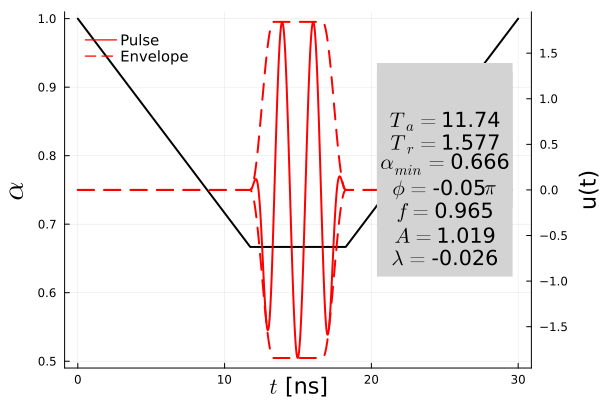

In [319]:
tmp_p = copy(p)
tmp_p[6] = 0
# tmp_p[9] = 0
tmp_p[5] = 0

tmp_p2 = copy(p)
tmp_p2[6] = 0
# tmp_p2[9] = 0
tmp_p2[5] = pi/2

pulse_plot = plot(times,
     [alpha(p,t) for t in times],
     ylim=(0.49,1.01),
     linewidth=2,
     color="black",label=nothing,
     labelfontsize=20,ticklabelfontsize=20,
      ylabel=L"$\alpha$",figsize=(1000,500))

t_scale = round(Int,limit_func(p[2],0,15)/30 * 1000)
plot!(twinx(),
      [times[t_scale:1000-t_scale],times, times],
      [[pulse(p,t) for t in times[t_scale:1000-t_scale]],
       [sqrt(pulse(tmp_p,t)^2 + pulse(tmp_p2,t)^2) for t in times],
       [-sqrt(pulse(tmp_p,t)^2 + pulse(tmp_p2,t)^2) for t in times]],
      linewidth=2,
      color=[:red :red :red],
      # ylim=(-2.5,2.5),
      ls = [:solid :dash :dash],
      label=["Pulse" "Envelope" ""],
      legend=:topleft,
      background_color_legend = nothing,
      foreground_color_legend = nothing,
      legendfontsize=10,
      labelfontsize=15,
      ticklabelfontsize=15,
      xlabel=L"$t$ [ns]",
      ylabel="u(t)")

p_scaled = copy(p)
p_scaled[2] = limit_func(p_scaled[2],0,15)
p_scaled[1] = limit_func(p_scaled[1],0,(30-2*p_scaled[2])/2)
p_scaled[4] = limit_func(p_scaled[4],0.5,1)

tmp_Es, tmp_ψs = eigs(KinPot12 + p_scaled[4] .* Potential3, nev=2, which=:SR, tol=0.0, maxiter=10000);
d = abs((tmp_ψs'*chargecoupling*tmp_ψs)[1,2])

annotate_string = (
      L"$T_a =$"*string(p_scaled[2])[1:5]*"\n"
      *L"$T_r =$"*string(p_scaled[1])[1:5]*"\n"
      *L"$\alpha_{min} =$"*string(p_scaled[4])[1:5]*"\n"
      *L"$\phi =$"*string((p_scaled[5]%(2pi))/pi)[1:5]*L"$\pi$"*"\n"
      *L"$f=$"*string(p_scaled[6]/real(tmp_Es[2]-tmp_Es[1]))[1:5]*"\n"
      # *L"$A =$"*string(p_scaled[7]*(30-2*p_scaled[2]-p_scaled[1])*d)[1:5]*"\n"
      *L"$A =$"*string(p_scaled[7]*d)[1:5]*"\n"
      *L"$\lambda =$"*string(p_scaled[9])[1:6])
annotate!(25,0.85,text("■", :lightgray, 120))
annotate!(25,0,text("■", :lightgray, 120)) #■ ▬
annotate!(25,0,annotate_string)

In [320]:
# savefig(plt,"Pulse_"*filenameadd*".pdf")

In [321]:
Es = eigvals(Matrix(KinPot12 + Potential3))
ψs = eigvecs(Matrix(KinPot12 + Potential3));

function f!(du, u, p, t)
    du[:] = -im .* ((KinPot12 + alpha(p,t) .* Potential3 + pulse(p,t) .* chargecoupling) * u)
end

forward_prob = ODEProblem(f!, ψs[:,1:2], (0.0, 30.0), p)
sol_f = solve(forward_prob, p=p, saveat=times, reltol=1e-10, abstol=1e-10) ;

In [322]:
occs = zeros(Float64,length(sol_f.t),2,2)

for (i,t) in enumerate(sol_f.t)
    tmp_Es, tmp_ψs = eigs(KinPot12 + alpha(p,t) .* Potential3, nev=2, which=:SR, tol=0.0, maxiter=10000);
    occs[i,:,:] = abs2.(tmp_ψs'*sol_f.u[i])
end

┌ Warning: Invalid negative or zero value -2.220446049250313e-15 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\utils.jl:85


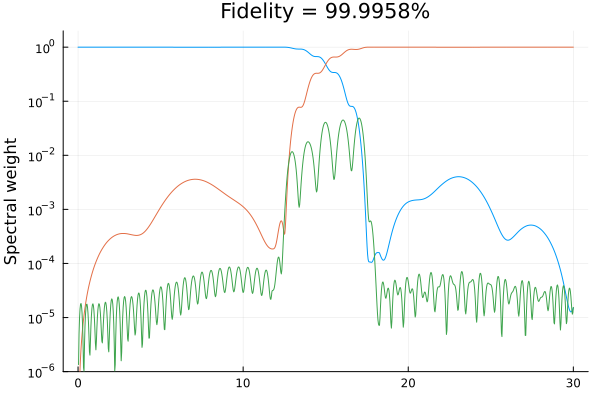

┌ Warning: Invalid negative or zero value -2.220446049250313e-15 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\utils.jl:85
┌ Warning: Invalid negative or zero value -2.220446049250313e-15 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\utils.jl:85


In [323]:
Occs_plot = plot(sol_f.t,
     [occs[:,:,1],1 .- sum(occs[:,:,1],dims=2)],
     yscale=:log10,
     ylim=(1e-6,2),
     legend=nothing,
     title = "Fidelity = "*string((1 - 0.5*(2-occs[end,1,2] - occs[end,2,1]))*100)[1:7]*"%",
     # xlabel="Time [ns]",
     ylabel="Spectral weight",figsize=(1000,500))

In [309]:
# savefig(plt,"Occs_"*filenameadd*".pdf")

┌ Warning: Invalid negative or zero value -2.220446049250313e-15 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\utils.jl:85


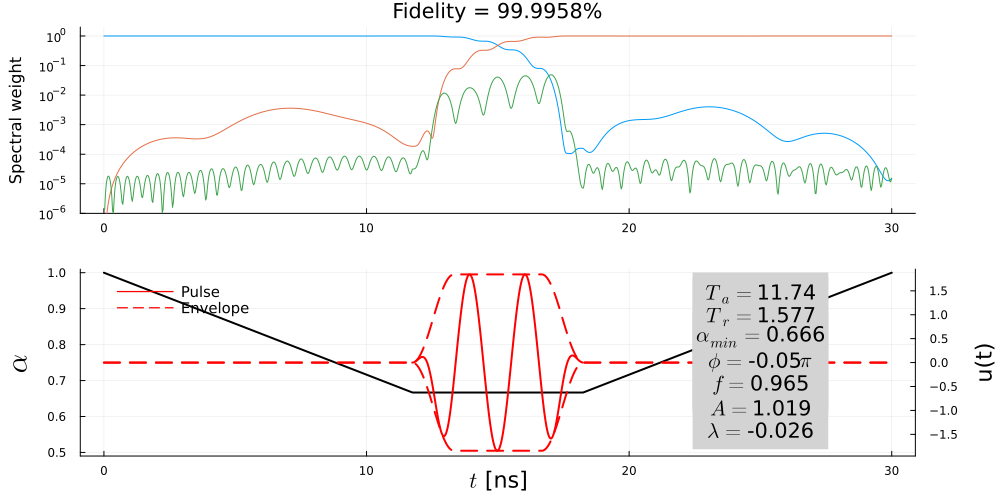

┌ Warning: Invalid negative or zero value -2.220446049250313e-15 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\utils.jl:85
┌ Warning: Invalid negative or zero value -2.220446049250313e-15 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\utils.jl:85


In [324]:
using Plots.PlotMeasures
plt = plot(Occs_plot,pulse_plot,layout=(2,1),size=(1000,500),bottom_margin=20px,right_margin=20px,left_margin=20px)
# display(plt)

In [325]:
savefig(plt,"plot_"*filenameadd*".pdf")

┌ Warning: Invalid negative or zero value -2.220446049250313e-15 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\utils.jl:85


"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\Production\\RobustPhiExtContinuousLoss\\SavedResults\\plot_m2.pdf"

In [326]:
function fidel(phi_ext,ps)
    Potential3 = get_Pot3(phi_ext)
    Es, ψs = eigs(KinPot12 + Potential3, nev=2, which=:SR, tol=0.0, maxiter=10000);

    function H!(du, u, p, t)
        du[:] = - im * (KinPot12 + alpha(p,t) .* Potential3 + pulse(p,t) .* chargecoupling) * u
    end

    forward_prob = ODEProblem(H!, ψs, (0.0, 30.0), ps)
    sol = solve(forward_prob, p=ps, save_everystep=false, reltol=1e-10, abstol=1e-10)

    UT = abs2.(ψs'*sol.u[end])
    return 0.5 * (2 - UT[1,2] - UT[2,1])
end    

fidel (generic function with 1 method)

In [327]:
phis = readdlm("../../RobustPhiExt/phis.txt")

tmp_losses = []
for phi in phis
    push!(tmp_losses,fidel(phi*pi,p))
end

In [315]:
writedlm("PhiLs_"*filenameadd*".txt",tmp_losses)

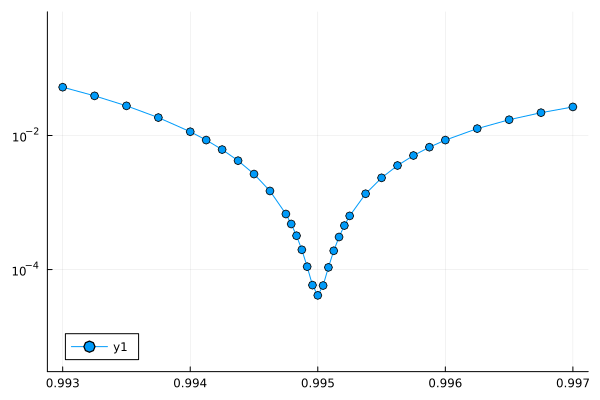

In [328]:
plot(phis,tmp_losses,
yscale=:log10,
marker=:o,
ylim=(3e-6,7e-1),
legend=:bottomleft)

In [282]:
names = ["m3_1" "mm30_1" "mm33_1" "mm30" "mm33"]
phils = [readdlm("PhiLs_"*name*".txt") for name in names]
phils = cat(phils...,dims=2)

33×5 Matrix{Float64}:
 0.62263    0.064649     0.0584954    0.0905184   0.0900612
 0.499942   0.0481742    0.0430177    0.0678263   0.0674712
 0.380663   0.0341366    0.0300335    0.0494169   0.0491313
 0.27191    0.0225826    0.0195948    0.0352483   0.0350194
 0.178267   0.0134731    0.0115779    0.0241228   0.0239543
 0.138008   0.00983567   0.00843494   0.0192873   0.0191509
 0.102469   0.00681418   0.00584942   0.0148216   0.0147164
 0.0718787  0.00440439   0.00380294   0.0107414   0.0106644
 0.0464631  0.00258661   0.00226734   0.00713748  0.00708312
 0.0264411  0.00131916   0.00119943   0.00414796  0.00410913
 ⋮                                                
 0.0432575  0.00047734   0.000544273  0.00545042  0.00540892
 0.0653889  0.000474626  0.000611792  0.00769085  0.0076519
 0.0907491  0.00040265   0.000658888  0.0100347   0.00999458
 0.11854    0.000291757  0.000720445  0.0125166   0.0124653
 0.147971   0.000178681  0.000839113  0.0152957   0.0152165
 0.208949   5.06964e-5 

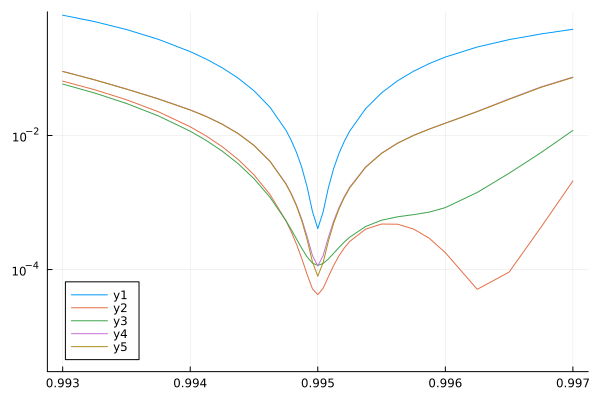

In [285]:
plot(phis,phils,yscale=:log10,
# marker=:o,
ylim=(3e-6,7e-1),
legend=:bottomleft)